# Hybrid Qudit Surface Code Graphs

In this notebook we are going to implement the HybridSurfaceCodeGraph class which allows us to create surface codes with qudits of varying dimensions. The dimensions depend on the lengths of permutations given by a dessin d'enfant (given by a constellation $[\sigma, \alpha, \phi]$. The permuation $\sigma$ gives the vertices of the graph of the dessin which is cellularly embedded in a Riemann surface. Each cycle of $\sigma$ has a length and determines a qudit (or infinite periodic/cyclic harmonic oscillator) of the same dimension/period as the length of the cycle of $\sigma$. Similarly, each cycle of $\phi$ determines a face of the embedded graph and determines a qudit of the same dimension as the length of the cycle of $\phi$. The nodes corresponding to cycles in $\alpha$ are all $2$-cycles and so define qubits, i.e. $2$-level systems (such as electrons). The coefficients in this implementation are in $\mathbb{Z}$ as apposed to the usual $\mathbb{Z}/2\mathbb{Z}$ coefficients used in standard qubit surface codes (ex. Kitaev's torus code). Because the dimension of each qudit in the surface code is different it is not clear what other coefficient might be useful. One may at some point want coefficients in $\mathbb{Z}/N\mathbb{Z}$ where $N = d_1^{n_1}d_2^{n_2} \cdots d_k^{n_k}$, where the $d_j^{n_j}$ are the dimensions of the qudits in the surface code. Using the Fundamental Theorem of Abelian Groups this would naturally decompose into a direct product of groups

$$ \prod_{j}\mathbb{Z}/p_j^{m_j}\mathbb{Z}. $$

where each $p_j$ is a prime number raised to some power $m_j$. This would be sufficient for an abelian gauge theory. We might also consider the group obtained by [amalgamated products](https://en.wikipedia.org/wiki/Free_product#Generalization:_Free_product_with_amalgamation) (see [also](https://unapologetic.wordpress.com/2007/03/03/amalgamated-free-products/) and [also](https://math.stackexchange.com/questions/958523/amalgamated-product-example), and [also here](https://encyclopediaofmath.org/wiki/Amalgam_of_groups)) that corresponds to an application of the [Seifert-van-Kampen Theorem](https://en.wikipedia.org/wiki/Seifert%E2%80%93Van_Kampen_theorem) (see [also](https://ncatlab.org/nlab/show/van+Kampen+theorem)) to the various disks that the dessin decomposes into (via $\phi$ and the face gluings for example, or via $\sigma$ and the open disks with half-edges eminating from the center of each disk). 


This may be implemented later on if there seems to be a need, but currently is not implemented and we just use $\mathbb{Z}$ coefficients. The coefficients that show up when computing boundaries are given by multisets. It is not obvious to me how one should adjust the gauge theory appropriately. 

## Surface Algebras and Hybrid Qudit Codes

Note that each qudit of dimension $d_j^{n_j}$ in a hybrid qudit code has a corresponding sequence of matrix algebras 

$$ M_{d_j^{1}}(\mathbb{C}) \to M_{d_j^{2}}(\mathbb{C}) \to \cdots  M_{d_j^{n_j}}(\mathbb{C}) \to \cdots M_{\infty}(\mathbb{C})$$

ending in the set of compact operators. The $\mathfrak{m}$-adic completion of the cyclic quiver with $d_j$ arrows, and $\mathfrak{m}$ the arrow ideal is constructed using powers of simple cycles in the quiver, giving topological neighborhoods to define the $\mathfrak{m}$-adic completion of the path algebra. We get the following as the completion, 

$$\begin{pmatrix}
\mathbb{C}[[t]] & (t) & \cdots & (t) \\
\mathbb{C}[[t]] & \mathbb{C}[[t]] & \cdots & (t) \\
\vdots & \vdots & \ddots & \vdots \\
\mathbb{C}[[t]] & \mathbb{C}[[t]] & \cdots & \mathbb{C}[[t]] \\
\end{pmatrix}$$

which is contained in

$$ M_{d_j}(\mathbb{C}) \otimes_{\mathbb{C}} \mathbb{C}[t, t^{-1}] = M_{d_j}(C^{\infty}(S^1)),$$ 

Here, $C^{\infty}(S^1)$ is continuous functions on the circle, and we have the [loop algebra](https://en.wikipedia.org/wiki/Loop_algebra) $\mathfrak{gl}_{n_j} \otimes_{\mathbb{C}} C^{\infty}(S^1)$. This is important since it is the analytic completion of the Leavitt path algebra associated to the cyclic quivers. It is in fact the graph $C^*$-algebra associated to the cyclic quivers. If we so desire we can also study the [Witt Algebra](https://en.wikipedia.org/wiki/Witt_algebra), or the [Virasoro algebra](https://en.wikipedia.org/wiki/Virasoro_algebra) important in conformal field theory and closely related to the loop algebra. 

We also note, that quotients of the cyclic quiver give Frobenius algebras, important for Topological Quantum Field Theories, and the definition of surface algebras in [Surface Algebras I: Dessins D'enfants, Surface Algebras, and Dessin Orders](https://arxiv.org/abs/1810.06750) shows how one forms a pullback of the Frobenius algebras/states for the surface codes associated to the dessin d'enfant we are interested in. 

The tensor product of Frobenius algebras, which is the composition in TQFTs (associated to cobordisms), over the base field of each of these matrix algebras, here $\mathbb{C}$, corresponds to a pullback, or fibre product of states very similar to the way tensor products of commutative algebras correspond to fibre products of the associated schemes. This is common in the "noncommutative algebra of functions as a noncommutative space" idea from noncommutative geometry.

In [1]:
pip install multiset

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show multiset

Name: multiset
Version: 3.0.1
Summary: An implementation of a multiset.
Home-page: https://github.com/wheerd/multiset
Author: Manuel Krebber
Author-email: admin@wheerd.de
License: MIT
Location: /Users/amelieschreiber/opt/anaconda3/lib/python3.8/site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## The HybridSurfaceCodeGraph Class

This implements the graph of a given dessin/constellation $[\sigma, \alpha, \phi]$, all of its topological properties as a $2$-dimensional cell complex (boundary maps and homology of chain complex), and gives visualizations of the graph.  

In [3]:
from collections import Counter
from typing import Tuple, List
import numpy as np

from networkx import MultiGraph
from networkx import nx
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation

import matplotlib.pyplot as plt
import multiset
from multiset import Multiset


# from SurfaceCodes.utilites import permlist_to_tuple


class HybridSurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.build_node_info()  # print dictionary for [sigma, alpha, phi]
        self.node_dict = self.sigma_dict, self.alpha_dict, self.phi_dict
        
        self.node_info = ["sigma:", self.sigma_dict, 
                          "alpha:", self.alpha_dict, 
                          "phi:", self.phi_dict]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)
            
        # Define the white and black nodes. White correspond to edges labeled by 
        # cycles in alpha. Black correspond to nodes labeled by cycles in sigma
        # (vertices) and phi (faces)
        self.black_nodes, self.white_nodes = bipartite.sets(self.code_graph)
        self.vertex_basis()
        self.edge_basis()
        self.face_basis()
        self.d_2()
        self.d_1()

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])
    
    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
        boundary1 = [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return boundary1
    
    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """
        boundary_list = Multiset()
        for edge in edges:
            boundary_list.update(Multiset(self.boundary_1(edge)))
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face
        """
        boundary2 = list(self.code_graph.neighbors(face))
        return boundary2

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """
        boundary_list = Multiset()
        for face in faces:
            boundary_list.update(Multiset(self.boundary_2(face)))
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        coboundary = self.code_graph.neighbors(star)
        return coboundary

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = Multiset()
        for star in stars:
            coboundary_list.update(Multiset(self.boundary_1(star)))
        return coboundary_list
    
    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        return coboundary2
    
    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = Multiset()
        for edge in edges:
            coboundary_list.update(Multiset(self.boundary_1(edge)))
        return coboundary_list

    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)
    
    
    def vertex_basis(self):
        self.v_basis_dict = dict()
        self.v_dict = dict()
        A = np.eye(len(self.sigma), dtype=np.uint8)
        for count, cycle in enumerate(self.sigma):
            self.v_dict[cycle] = count
            self.v_basis_dict[cycle] = A[:, count]

    def edge_basis(self):
        self.e_basis_dict = dict()
        self.e_dict = dict()
        B = np.eye(len(self.alpha), dtype=np.uint8)
        for count, cycle in enumerate(self.alpha):
            self.e_dict[cycle] = count
            self.e_basis_dict[cycle] = B[count, :].reshape(1,-1)

    def face_basis(self):
        self.f_basis_dict = dict()
        self.f_dict = dict()
        C = np.eye(len(self.phi), dtype=np.uint8)
        for count, cycle in enumerate(self.phi):
            self.f_dict[cycle] = count
            self.f_basis_dict[cycle] = C[count, :].reshape(1,-1)

    def d_2(self):
        """
        Create the matrix D2 for the differential d_2 in the chain complex
        that maps faces to their boundary edges. This can be used in the homology
        class as one of the input matrices.
        :return: matrix D2 of the differential d_2
        """
        self.D2 = np.zeros(len(self.e_basis_dict), dtype=np.uint8)
        for cycle in self.phi:
            bd = self.boundary_2(cycle)
            if bd != []:
                image = sum([self.e_basis_dict[edge] for edge in bd])
            else:
                image = np.zeros(len(self.e_basis_dict))
            self.D2 = np.vstack((self.D2, image))
        self.D2 = np.array(self.D2[1:, :]).T
    
    def d_1(self):
        """
        Create the matrix D1 for the differential d_1 in the chain complex
        that maps edges to their boundary vertices. This can be used in the homology
        class as one of the input matrices
        :return: matrix D1 of the differential d_1
        """
        self.D1 = np.zeros(len(self.v_basis_dict), dtype=np.uint8)
        for cycle in self.alpha:
            bd = self.boundary_1(cycle)
            if bd != []:
                image = sum([self.v_basis_dict[vertex] for vertex in bd])
            else:
                image = np.zeros(len(self.v_basis_dict))
            self.D1 = np.vstack((self.D1, image))
        self.D1 = np.array(self.D1[1:, :]).T
    
    def draw(self, node_type='', layout = ''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices 
        corresponding to the qubit indices for the surface code
        """
        if not node_type in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
        
        if layout == 'spring':
            pos=nx.spring_layout(self.code_graph)
        if layout == 'spectral':
            pos=nx.spectral_layout(self.code_graph)
        if layout == 'planar':
            pos=nx.planar_layout(self.code_graph)
        if layout == 'shell':
            pos=nx.shell_layout(self.code_graph)
        if layout == 'circular':
            pos=nx.circular_layout(self.code_graph)
        if layout == 'spiral':
            pos=nx.spiral_layout(self.code_graph)
        if layout == 'random':
            pos=nx.random_layout(self.code_graph)
        # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.alpha),
                       node_color='c',
                       node_size=500,
                    alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.sigma),
                       node_color='b',
                       node_size=500,
                    alpha=0.6)
         # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.phi),
                       node_color='r',
                       node_size=500,
                    alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels={}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)
        
        # plt.axis('off')
        # plt.savefig("labels_and_colors.png") # save as png
        plt.show() # display

Much of this class works in a very similar way to the SurfaceCodeGraph class, which can be found [here](https://github.com/The-Singularity-Research/SurfaceCodes). We first define a constellation by defining $\sigma$ and $\alpha$.

In [4]:
sigma = ((0,1,2),(3,4,5),(6,7))
alpha = ((0,3),(1,6),(2,4),(5,7))
SCG = HybridSurfaceCodeGraph(sigma, alpha)
SCG

The `draw` method draws the graph with face nodes in red, vertex nodes in blue, and edge nodes in cyan. The 'cycles' option labels the nodes by the corresponding cycles.

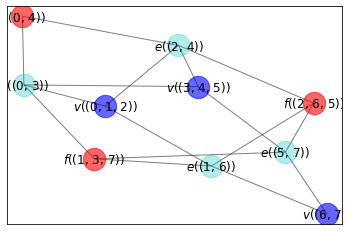

In [5]:
SCG.draw('cycles', 'spring')

We can also print $\sigma$, $\alpha$, and $\phi$ to get a tuple of tuples (cycles).

In [6]:
SCG.phi

((0, 4), (1, 3, 7), (2, 6, 5))

The `node_info` prints a dictionary for $\sigma$, $\alpha$, and $\phi$.

In [7]:
SCG.node_info

['sigma:',
 {(0, 1, 2): 0, (3, 4, 5): 1, (6, 7): 2},
 'alpha:',
 {(0, 3): 6, (1, 6): 7, (2, 4): 8, (5, 7): 9},
 'phi:',
 {(0, 4): 3, (1, 3, 7): 4, (2, 6, 5): 5}]

We can also print off all of the nodes in the graph.

In [8]:
SCG.code_graph.nodes

NodeView(((0, 1, 2), (3, 4, 5), (6, 7), (0, 4), (1, 3, 7), (2, 6, 5), (0, 3), (1, 6), (2, 4), (5, 7)))

The following prints of the "black nodes" and "white nodes". Black corresponds to vertex and face nodes, and white corrsponds to edge nodes.

In [9]:
bipartite.sets(SCG.code_graph)

({(0, 1, 2), (0, 4), (1, 3, 7), (2, 6, 5), (3, 4, 5), (6, 7)},
 {(0, 3), (1, 6), (2, 4), (5, 7)})

Or, we can print black nodes and white nodes individually. 

In [10]:
SCG.white_nodes

{(0, 3), (1, 6), (2, 4), (5, 7)}

In [11]:
SCG.black_nodes

{(0, 1, 2), (0, 4), (1, 3, 7), (2, 6, 5), (3, 4, 5), (6, 7)}

The other option for drawing the graph is `'dict'` which labels the nodes by their indices in the `node_info dictionary`.

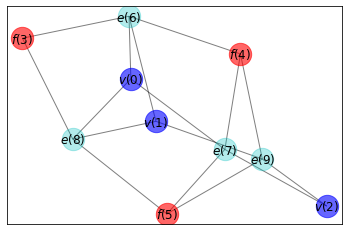

In [12]:
SCG.draw('dict', 'spring')

We think of each node as being a periodic/cyclic harmonic oscillator similar to Gerard t'Hooft's [cogwheel model](https://link.springer.com/chapter/10.1007/978-3-319-41285-6_12). Note, in []() we use the shift operator, 

$$\begin{pmatrix} 
0 & 0 & \cdots & 0 & 0 & \mathfrak{m} \\ 
1 & 0 & \cdots & 0 & 0 & 0 \\
0 & 1 & \cdots & 0 & 0 & 0\\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & \cdots & 1 & 0 & 0\\
0 & 0 & \cdots & 0 & 1 & 0
\end{pmatrix} $$

where $\mathfrak{m}$ is a maximal ideal. We might also use the shift operator, 

$$\begin{pmatrix} 
0 & 0 & \cdots & 0 & 0 & \zeta \\ 
1 & 0 & \cdots & 0 & 0 & 0 \\
0 & 1 & \cdots & 0 & 0 & 0\\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & \cdots & 1 & 0 & 0\\
0 & 0 & \cdots & 0 & 1 & 0
\end{pmatrix} $$

where $\zeta$ is some root of unity. The [clock and shift operators](https://en.wikipedia.org/wiki/Generalizations_of_Pauli_matrices) generate a generalization of the Pauli group on a qudit. We can also consider gluings of noncommutative tori and Toeplitz matrices.

We can compute the Euler characteristic of the dessin.

In [13]:
SCG.euler_characteristic()

2

We can also compute the genus.

In [14]:
SCG.genus()

0

There are boundary and coboundary operators to compute the boundary and coboundary of lists of vertices, edges, or faces. `del_1` and `del_2` as well as `delta_1` and `delta_2` take into account multiplicity allowing for coefficients in $\mathbb{Z}$.

In [15]:
SCG.boundary_2((0,4))

[(0, 3), (2, 4)]

In [16]:
SCG.boundary_2((1,3,7))

[(0, 3), (1, 6), (5, 7)]

In [17]:
SCG.boundary_1((0,3))

[(0, 1, 2), (3, 4, 5)]

In [18]:
SCG.boundary_1((1,6))

[(0, 1, 2), (6, 7)]

In [19]:
SCG.del_2([(0, 4)])

Multiset({(0, 3): 1, (2, 4): 1})

In [20]:
SCG.del_2([(1,3,7)])

Multiset({(0, 3): 1, (1, 6): 1, (5, 7): 1})

In [21]:
SCG.del_2([(0, 4), (1,3,7)])

Multiset({(0, 3): 2, (2, 4): 1, (1, 6): 1, (5, 7): 1})

To define basis vectors for the vector spaces in the chain complex,

$$C_2 \to C_1 \to C_0,$$

which might also be labeled

$$F \to E \to V$$

we have the following methods.

In [22]:
SCG.f_basis_dict

{(0, 4): array([[1, 0, 0]], dtype=uint8),
 (1, 3, 7): array([[0, 1, 0]], dtype=uint8),
 (2, 6, 5): array([[0, 0, 1]], dtype=uint8)}

In [23]:
SCG.e_basis_dict

{(0, 3): array([[1, 0, 0, 0]], dtype=uint8),
 (1, 6): array([[0, 1, 0, 0]], dtype=uint8),
 (2, 4): array([[0, 0, 1, 0]], dtype=uint8),
 (5, 7): array([[0, 0, 0, 1]], dtype=uint8)}

In [24]:
SCG.v_basis_dict

{(0, 1, 2): array([1, 0, 0], dtype=uint8),
 (3, 4, 5): array([0, 1, 0], dtype=uint8),
 (6, 7): array([0, 0, 1], dtype=uint8)}

We also have matrix representations of the boundary operators $\partial_2: C_2 \to C_1$ and $\partial_1: C_1 \to C_0$, we have the following methods.

In [25]:
SCG.D2

array([[1, 1, 0],
       [0, 1, 1],
       [1, 0, 1],
       [0, 1, 1]], dtype=uint8)

In [26]:
SCG.D1

array([[1, 1, 1, 0],
       [1, 0, 1, 1],
       [0, 1, 0, 1]], dtype=uint8)

In this example, with 

$$
\sigma = ((0,1,2),(3,4,5),(6,7)), \quad 
\alpha = ((0,3),(1,6),(2,4),(5,7))
$$

We have two cyclic quivers, each with three arrows that get glued together. This gives us two matrix algebras, 

$$
\begin{pmatrix}
\mathbb{C}[[x]] & (x) & (x) \\
\mathbb{C}[[x]] & \mathbb{C}[[x]] & (x) \\
\mathbb{C}[[x]] & \mathbb{C}[[x]] & \mathbb{C}[[x]] \\
\end{pmatrix}
$$

and 

$$
\begin{pmatrix}
\mathbb{C}[[y]] & (y) & (y) \\
\mathbb{C}[[y]] & \mathbb{C}[[y]] & (y) \\
\mathbb{C}[[y]] & \mathbb{C}[[y]] & \mathbb{C}[[y]] \\
\end{pmatrix}.
$$

These are the $\mathfrak{m}$-adic completions of the path algebras of the two cyclic quivers. They are contained in the loop algebras $\mathfrak{gl}_3((x))$ and $\mathfrak{gl}_3((y))$. The two algebras above get glued together via a pullback along an isomorphism of the base field $\mathbb{C}$. This corresponds to states being glued. Taking the tensor product of $\mathfrak{gl}_3((x))$ and $\mathfrak{gl}_3((y))$ (over $\mathbb{C}[[x, y]]/(xy)$ or over $\mathbb{C}$?) gives the corresponding operator alegra (i.e. the algebra of noncommutative functions on the glued states)? We might also include the three copies of $\mathfrak{gl}_2((t_i))$ for $i=1,2,3$ given by the vertices of the dessin corresponding to $\alpha$. This would make the center of the glued algebra isomorphic to $\mathbb{C}[[z_1, z_2, z_3, z_4, z_5]]/(z_iz_j)_{i \neq j}$. 

The glued matrix algebra should be isomorhic to:

$$
\begin{pmatrix}
\mathbb{C}[[x,y]]/(xy) & (x) & (x) & 0 & 0 & 0 \\
\mathbb{C}[[x]] & \mathbb{C}[[x,y]]/(xy) & (x) & 0 & 0 & 0 \\
\mathbb{C}[[x]] & \mathbb{C}[[x]] & \mathbb{C}[[x,y]]/(xy) & 0 & 0 & 0 \\
0 & 0 & 0 & \mathbb{C}[[x,y]]/(xy) & (y) & (y) \\
0 & 0 & 0 & \mathbb{C}[[y]] & \mathbb{C}[[x,y]]/(xy) & (y) \\
0 & 0 & 0 & \mathbb{C}[[y]] & \mathbb{C}[[y]] & \mathbb{C}[[x,y]]/(xy) \\
\end{pmatrix}.
$$

The purpose of this was of course to generalize surface codes to the case of hybrid qudits, i.e. qudits of differing dimensions. As a secondary goal we also wish to give a way to implement the Hilbert-Polya conjecture using the mathematics mentioned in some of the following papers which served as inspiration. 

[Synthesis of multi-qudit Hybrid and d-valued Quantum Logic Circuits by Decomposition](https://arxiv.org/pdf/quant-ph/0511019v1.pdf)

[Quantum gates on hybrid qudits](https://arxiv.org/pdf/quant-ph/0211185.pdf)

[Qudit surface codes and gauge theory with finite
cyclic groups](https://arxiv.org/pdf/quant-ph/0609070.pdf)

In the following papers, we view cyclic quivers (which are glued together) as (local) TQFTs since cyclic quivers have Frobenius algebras as quotients of their path algebras. So surface algebras give gluings of local TQFTs via their quotients. The quotients in some cases give [Brauer graph algebras](https://arxiv.org/abs/1612.00061). 

[Affine Schubert Varieties and Circular Complexes](https://arxiv.org/pdf/math/0210151.pdf)

This is more related to L-functions
[SURFACE ALGEBRAS I: DESSINS D’ENFANTS, SURFACE ALGEBRAS, AND DESSIN
ORDERS](https://arxiv.org/pdf/1810.06750.pdf)

This gives connections to Geometric Langlands
[SURFACE ALGEBRAS AND SURFACE ORDERS II: AFFINE BUNDLES ON CURVES](https://arxiv.org/pdf/1812.00621.pdf)

### Related Code (Ribbon Graphs in SageMath)

The following is closely related and implemented in SageMath:

[Ribbon Graphs](https://doc.sagemath.org/html/en/reference/discrete_geometry/sage/geometry/ribbon_graph.html)

[Draw Ribbon Graphs](https://trac.sagemath.org/ticket/27080)

The SageMath class for ribbon graphs is `sage.geometry.ribbon_graph.RibbonGraph(sigma, alpha)`. Here $\alpha$ (`rho` on the SageMath page) are the same permutations used to define a dessin d'enfant, and may in general be a $2$-constellation $[\sigma, \rho]$. An similar introduction to the one we have given on dessins can be found there on the SageMath page. 

#### References related to the following use of ribbon graphs (which are essentially dessins d'enfant): 

[Intersection theory on the moduli space of curves and the matrix Airy function](https://projecteuclid.org/journals/communications-in-mathematical-physics/volume-147/issue-1/Intersection-theory-on-the-moduli-space-of-curves-and-the/cmp/1104250524.full)

### References Related to TQFT and Cyclic Quivers

[Frobenius algebras and
2D topological quantum field theories](https://mat.uab.cat/~kock/TQFT/FS.pdf)

[Frobenius Algebras and their Quiver](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/85780D4DB3ED9E8AC11A4D4DAF8174FE/S0008414X00028133a.pdf/frobenius-algebras-and-their-quivers.pdf)

[Construct Bi-Frobenius Algebras via Quivers](https://www.jstor.org/stable/43686702)